In [2]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=0f076fb8c22c0673ec48ee820b5ce6549859328fc97fd42b175bc98f030a4c73
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta


In [5]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta


Fetching AAPL data from 2015-03-05 to 2025-03-02...


[*********************100%***********************]  1 of 1 completed


Converting MultiIndex columns to single level...
Calculating technical indicators...
Available columns: ['Close', 'High', 'Low', 'Open', 'Volume', 'SMA_50', 'SMA_200', 'RSI_14', 'MACD_Line', 'MACD_Signal', 'MACD_Histogram']
Handling NaN values...
Saving to stock_data.csv...
Creating visualization...
Visualization saved as stock_analysis.png


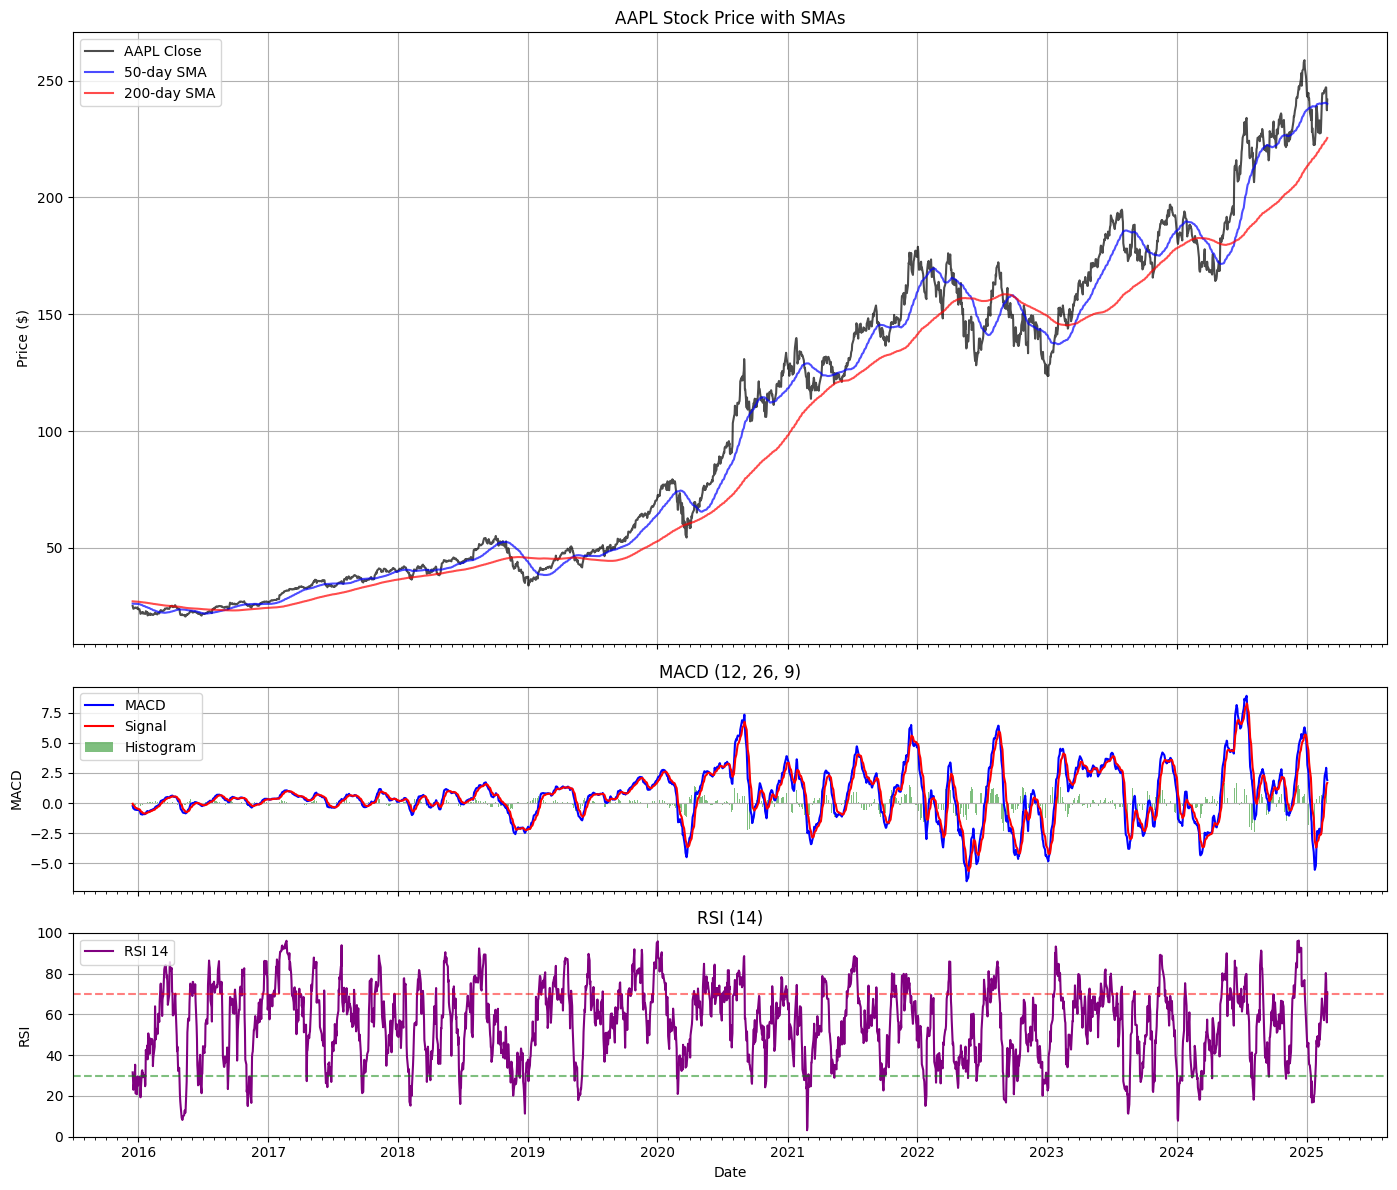

Analysis complete!


In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Calculate the date range (10 years from today)
end_date = datetime.now()
start_date = end_date - timedelta(days=365*10)

# Fetch historical stock data
print(f"Fetching AAPL data from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}...")
stock_data = yf.download('AAPL', start=start_date, end=end_date)

# Check if there's a MultiIndex in columns and fix it if needed
if isinstance(stock_data.columns, pd.MultiIndex):
    print("Converting MultiIndex columns to single level...")
    stock_data.columns = [col[0] if isinstance(col, tuple) else col for col in stock_data.columns]

# Ensure the data is in chronological order
stock_data = stock_data.sort_index()

print("Calculating technical indicators...")
# Calculate SMAs
stock_data['SMA_50'] = stock_data['Close'].rolling(window=50).mean()
stock_data['SMA_200'] = stock_data['Close'].rolling(window=200).mean()

# Calculate RSI (14-day)
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

stock_data['RSI_14'] = calculate_rsi(stock_data['Close'], window=14)

# Calculate MACD (12, 26, 9)
def calculate_macd(data, fast=12, slow=26, signal=9):
    ema_fast = data.ewm(span=fast, adjust=False).mean()
    ema_slow = data.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    histogram = macd_line - signal_line
    return macd_line, signal_line, histogram

stock_data['MACD_Line'], stock_data['MACD_Signal'], stock_data['MACD_Histogram'] = calculate_macd(stock_data['Close'])

# Print available columns for debugging
print("Available columns:", stock_data.columns.tolist())

# Handle NaN values
print("Handling NaN values...")
stock_data = stock_data.dropna()

# Save to CSV
print("Saving to stock_data.csv...")
stock_data.to_csv('stock_data.csv')

# Create visualization
print("Creating visualization...")
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]})

# Format date on x-axis
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

# Plot 1: Price with SMAs
axes[0].plot(stock_data.index, stock_data['Close'], label='AAPL Close', color='black', alpha=0.7)
axes[0].plot(stock_data.index, stock_data['SMA_50'], label='50-day SMA', color='blue', alpha=0.7)
axes[0].plot(stock_data.index, stock_data['SMA_200'], label='200-day SMA', color='red', alpha=0.7)
axes[0].set_title('AAPL Stock Price with SMAs')
axes[0].set_ylabel('Price ($)')
axes[0].legend(loc='upper left')
axes[0].grid(True)

# Plot 2: MACD
axes[1].plot(stock_data.index, stock_data['MACD_Line'], label='MACD', color='blue')
axes[1].plot(stock_data.index, stock_data['MACD_Signal'], label='Signal', color='red')
axes[1].bar(stock_data.index, stock_data['MACD_Histogram'], label='Histogram', color='green', alpha=0.5)
axes[1].set_title('MACD (12, 26, 9)')
axes[1].set_ylabel('MACD')
axes[1].legend(loc='upper left')
axes[1].grid(True)

# Plot 3: RSI
axes[2].plot(stock_data.index, stock_data['RSI_14'], label='RSI 14', color='purple')
axes[2].axhline(y=70, color='red', linestyle='--', alpha=0.5)
axes[2].axhline(y=30, color='green', linestyle='--', alpha=0.5)
axes[2].set_title('RSI (14)')
axes[2].set_ylabel('RSI')
axes[2].set_ylim(0, 100)
axes[2].legend(loc='upper left')
axes[2].grid(True)

# Format x-axis for dates
axes[2].xaxis.set_major_locator(years)
axes[2].xaxis.set_major_formatter(years_fmt)
axes[2].xaxis.set_minor_locator(months)
axes[2].set_xlabel('Date')

# Add error handling for the plot
try:
    plt.tight_layout()
    plt.savefig('stock_analysis.png', dpi=300)
    print("Visualization saved as stock_analysis.png")
    plt.show()
except Exception as e:
    print(f"Error plotting: {e}")
    print("Available columns:", stock_data.columns.tolist())

print("Analysis complete!")

In [9]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import datetime

# Load the stock data
print("Loading the stock data...")
stock_data = pd.read_csv('stock_data.csv', index_col=0, parse_dates=True)

# Convert index to datetime if not already
if not isinstance(stock_data.index, pd.DatetimeIndex):
    stock_data.index = pd.to_datetime(stock_data.index)

# Sort by date to ensure chronological order
stock_data = stock_data.sort_index()

print(f"Data ranges from {stock_data.index.min().date()} to {stock_data.index.max().date()}")

# Define the features to use (exclude MACD and RSI since they're derived from price)
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_50', 'SMA_200']
target = 'Close'  # Predicting the closing price

# Create train and test split based on date
train_data = stock_data[stock_data.index < '2020-01-01']
test_data = stock_data[(stock_data.index >= '2020-01-01') & (stock_data.index < '2024-01-01')]

print(f"Train data: {train_data.index.min().date()} to {train_data.index.max().date()}")
print(f"Test data: {test_data.index.min().date()} to {test_data.index.max().date()}")

# Initialize scalers
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler on training data only to avoid lookahead bias
feature_scaler.fit(train_data[features])
target_scaler.fit(train_data[[target]])

# Transform both train and test data
train_scaled_features = feature_scaler.transform(train_data[features])
test_scaled_features = feature_scaler.transform(test_data[features])

train_scaled_target = target_scaler.transform(train_data[[target]])
test_scaled_target = target_scaler.transform(test_data[[target]])

def create_sequences(features, target, seq_length):
    """
    Create sequences of seq_length time steps with corresponding target values.
    Each sequence predicts the next timestep's target value.
    """
    X, y = [], []
    for i in range(len(features) - seq_length):
        # Sequence of features
        X.append(features[i:i+seq_length])
        # Target is the next timestep's target value
        y.append(target[i+seq_length])
    return np.array(X), np.array(y)

# Create sequences with a window of 60 time steps
sequence_length = 60
print(f"Creating sequences with {sequence_length} time steps...")

X_train, y_train = create_sequences(train_scaled_features, train_scaled_target, sequence_length)
X_test, y_test = create_sequences(test_scaled_features, test_scaled_target, sequence_length)

print(f"Train sequences shape: {X_train.shape}, Train targets shape: {y_train.shape}")
print(f"Test sequences shape: {X_test.shape}, Test targets shape: {y_test.shape}")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

print("Tensor shapes:")
print(f"X_train_tensor: {X_train_tensor.shape}")
print(f"y_train_tensor: {y_train_tensor.shape}")
print(f"X_test_tensor: {X_test_tensor.shape}")
print(f"y_test_tensor: {y_test_tensor.shape}")

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size_train = 64
batch_size_test = 1

train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

print(f"Train DataLoader: {len(train_loader)} batches")
print(f"Test DataLoader: {len(test_loader)} batches")

# Verify a sample batch from the train loader
for X_batch, y_batch in train_loader:
    print(f"Sample batch shapes - X: {X_batch.shape}, y: {y_batch.shape}")
    break

# Create a function to inverse transform predictions later
def inverse_transform_predictions(scaled_predictions):
    """Convert scaled predictions back to original scale"""
    # Reshape predictions to 2D if they're not already
    if len(scaled_predictions.shape) == 1:
        scaled_predictions = scaled_predictions.reshape(-1, 1)
    return target_scaler.inverse_transform(scaled_predictions)

print("Data preprocessing complete!")

Loading the stock data...
Data ranges from 2015-12-16 to 2025-02-28
Train data: 2015-12-16 to 2019-12-31
Test data: 2020-01-02 to 2023-12-29
Creating sequences with 60 time steps...
Train sequences shape: (957, 60, 7), Train targets shape: (957, 1)
Test sequences shape: (946, 60, 7), Test targets shape: (946, 1)
Tensor shapes:
X_train_tensor: torch.Size([957, 60, 7])
y_train_tensor: torch.Size([957, 1])
X_test_tensor: torch.Size([946, 60, 7])
y_test_tensor: torch.Size([946, 1])
Train DataLoader: 15 batches
Test DataLoader: 946 batches
Sample batch shapes - X: torch.Size([64, 60, 7]), y: torch.Size([64, 1])
Data preprocessing complete!


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda import is_available as cuda_available

class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.2):
        """
        Initialize the LSTM model for stock price prediction.

        Args:
            input_size (int): Number of features in the input data
            hidden_size (int): Number of features in the hidden state of LSTM
            num_layers (int): Number of recurrent layers
            dropout (float): Dropout rate between LSTM layers
        """
        super(StockLSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # First LSTM layer followed by LayerNorm
        self.lstm1 = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True
        )
        self.layernorm1 = nn.LayerNorm(hidden_size)
        self.dropout1 = nn.Dropout(dropout)

        # Second LSTM layer followed by LayerNorm
        self.lstm2 = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            batch_first=True
        )
        self.layernorm2 = nn.LayerNorm(hidden_size)
        self.dropout2 = nn.Dropout(dropout)

        # Linear output layer for regression
        self.fc = nn.Linear(hidden_size, 1)

        # Move to GPU if available
        self.device = torch.device("cuda" if cuda_available() else "cpu")
        self.to(self.device)

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            x (Tensor): Input tensor of shape (batch_size, seq_length, input_size)

        Returns:
            Tensor: Predicted values of shape (batch_size, 1)
        """
        # Move input to device
        x = x.to(self.device)
        batch_size = x.size(0)

        # First LSTM layer
        out, _ = self.lstm1(x)
        out = self.layernorm1(out)
        out = self.dropout1(out)

        # Second LSTM layer
        out, _ = self.lstm2(out)
        out = self.layernorm2(out)
        out = self.dropout2(out)

        # We only need the output from the last time step
        out = out[:, -1, :]

        # Linear layer for prediction
        out = self.fc(out)

        return out


def initialize_model(input_features):
    """
    Initialize the LSTM model with the specified hyperparameters.

    Args:
        input_features (int): Number of features in the input data

    Returns:
        tuple: (model, optimizer, criterion)
    """
    model = StockLSTM(input_size=input_features, hidden_size=128, num_layers=2, dropout=0.2)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # Print model architecture and parameter count
    print(model)
    print(f"Model device: {model.device}")

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")

    return model, optimizer, criterion

num_features = 7
model, optimizer, criterion = initialize_model(num_features)

StockLSTM(
  (lstm1): LSTM(7, 128, batch_first=True)
  (layernorm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(128, 128, batch_first=True)
  (layernorm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)
Model device: cpu
Total Parameters: 202,881
Trainable Parameters: 202,881


In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import time
from datetime import datetime

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class EarlyStopping:
    """Early stopping to prevent overfitting"""
    def __init__(self, patience=15, min_delta=0, path='lstm_model.pth'):
        """
        Args:
            patience (int): How many epochs to wait after validation loss minimum before stopping
            min_delta (float): Minimum change in loss to qualify as improvement
            path (str): Path where to save the best model
        """
        self.patience = patience
        self.min_delta = min_delta
        self.path = path
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                print(f"Early stopping triggered after {self.counter} epochs without improvement")

    def save_checkpoint(self, model):
        """Save model when validation loss decreases"""
        torch.save(model.state_dict(), self.path)
        print(f"Validation loss decreased. Saving model to {self.path}")


def plot_losses(train_losses, val_losses, save_path='loss_curves.png'):
    """Plot and save training and validation loss curves"""
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path)
    plt.close()
    print(f"Loss curves saved to {save_path}")


def train_model(model, train_loader, val_loader, criterion, optimizer, max_epochs=200, patience=15,
                gradient_clip_max_norm=1.0, device=None):
    """
    Train the LSTM model with early stopping and gradient clipping

    Args:
        model: The LSTM model to train
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        criterion: Loss function
        optimizer: Optimizer
        max_epochs: Maximum number of epochs to train
        patience: Patience for early stopping
        gradient_clip_max_norm: Maximum norm for gradient clipping
        device: Device to use for training (cuda or cpu)

    Returns:
        tuple: (trained model, train_losses, val_losses)
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    print(f"Training on {device}")

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience)

    # Lists to store losses for plotting
    train_losses = []
    val_losses = []
    lr_history = []

    start_time = time.time()

    for epoch in range(max_epochs):
        # Training phase
        model.train()
        train_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            loss.backward()

            # Gradient clipping
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip_max_norm)

            optimizer.step()

            train_loss += loss.item() * X_batch.size(0)

        # Calculate average training loss
        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        lr_history.append(current_lr)

        # Validation phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

                val_loss += loss.item() * X_batch.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        # Print progress
        elapsed_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{max_epochs} | "
              f"Train Loss: {train_loss:.6f} | "
              f"Val Loss: {val_loss:.6f} | "
              f"LR: {current_lr:.6f} | "
              f"Time: {elapsed_time:.2f}s")

        # Check early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Load best model
    model.load_state_dict(torch.load(early_stopping.path))

    # Plot the learning rate
    plt.figure(figsize=(10, 4))
    plt.plot(lr_history)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.grid(True)
    plt.savefig('learning_rate.png')
    plt.close()

    return model, train_losses, val_losses


# Load the training dataset
print("Loading data...")

# Load preprocessed data if it exists, otherwise create from data preparation script
try:
    # Load the preprocessed tensors if available
    print("Attempting to load preprocessed data...")
    X_train_tensor = torch.load('X_train_tensor.pt')
    y_train_tensor = torch.load('y_train_tensor.pt')

    print(f"Loaded data shapes: X={X_train_tensor.shape}, y={y_train_tensor.shape}")
except FileNotFoundError:
    print("Preprocessed data not found. Please run data preparation script first.")

# Create full training dataset
full_train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Split into training and validation sets (80-20 split)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_train_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, optimizer and loss function
input_features = X_train_tensor.shape[2]  # Number of features
model, optimizer, criterion = initialize_model(input_features)

# Create a directory for saving results
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_dir = f"training_results_{timestamp}"
os.makedirs(results_dir, exist_ok=True)

# Train the model
print(f"Starting training with max {200} epochs and early stopping patience {15}...")
model, train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    max_epochs=200,
    patience=15,
    gradient_clip_max_norm=1.0
)

# Plot and save losses
plot_losses(train_losses, val_losses, save_path=f"{results_dir}/loss_curves.png")

print("Training completed!")



Loading data...
Attempting to load preprocessed data...
Preprocessed data not found. Please run data preparation script first.
Train dataset size: 765
Validation dataset size: 192
StockLSTM(
  (lstm1): LSTM(7, 128, batch_first=True)
  (layernorm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(128, 128, batch_first=True)
  (layernorm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)
Model device: cpu
Total Parameters: 202,881
Trainable Parameters: 202,881
Starting training with max 200 epochs and early stopping patience 15...
Training on cpu


<ipython-input-14-af8154ab7410>:183: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_train_tensor = torch.load('X_train_tensor.pt')


Epoch 1/200 | Train Loss: 0.585027 | Val Loss: 0.038317 | LR: 0.001000 | Time: 2.78s
Validation loss decreased. Saving model to lstm_model.pth
Epoch 2/200 | Train Loss: 0.056232 | Val Loss: 0.016127 | LR: 0.001000 | Time: 5.29s
Validation loss decreased. Saving model to lstm_model.pth
Epoch 3/200 | Train Loss: 0.027134 | Val Loss: 0.008176 | LR: 0.001000 | Time: 7.77s
Validation loss decreased. Saving model to lstm_model.pth
Epoch 4/200 | Train Loss: 0.015158 | Val Loss: 0.006558 | LR: 0.001000 | Time: 11.17s
Validation loss decreased. Saving model to lstm_model.pth
Epoch 5/200 | Train Loss: 0.011607 | Val Loss: 0.003392 | LR: 0.001000 | Time: 14.17s
Validation loss decreased. Saving model to lstm_model.pth
Epoch 6/200 | Train Loss: 0.009168 | Val Loss: 0.000699 | LR: 0.001000 | Time: 16.67s
Validation loss decreased. Saving model to lstm_model.pth
Epoch 7/200 | Train Loss: 0.005283 | Val Loss: 0.000562 | LR: 0.001000 | Time: 19.18s
Validation loss decreased. Saving model to lstm_model

<ipython-input-14-af8154ab7410>:161: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stopping.path))


Loss curves saved to training_results_20250302_111607/loss_curves.png
Training completed!


In [15]:
import pandas as pd
import numpy as np

class Backtester:
    def __init__(self, data, threshold=0.005, transaction_cost=0.001):
        """
        Parameters:
          data : pd.DataFrame
              Must contain at least a 'close' column.
          threshold : float
              The percentage threshold for generating signals (0.005 for 0.5%).
          transaction_cost : float
              Cost per trade (0.001 for 0.1%).
        """
        self.data = data.copy()
        self.threshold = threshold
        self.transaction_cost = transaction_cost

    def generate_predictions(self):
        """
        Generates a dummy prediction using a rolling average.
        To avoid lookahead bias the predictions are shifted forward by 1 day.
        """
        # Use a simple 3-day rolling mean as the prediction model.
        self.data['pred_price'] = self.data['close'].rolling(window=3, min_periods=1).mean()
        # Shift predictions forward so that today's prediction is used for tomorrow's decision.
        self.data['pred_price'] = self.data['pred_price'].shift(1)
        return self.data['pred_price']

    def generate_signals(self):
        """
        Generates trading signals based on the prediction.
          - Buy (signal=1): When predicted price is more than current_close * (1 + threshold)
          - Sell (signal=-1): When predicted price is less than current_close * (1 - threshold)
          - Else: 0 (hold)
        """
        self.data['signal'] = 0
        self.data.loc[self.data['pred_price'] > self.data['close'] * (1 + self.threshold), 'signal'] = 1
        self.data.loc[self.data['pred_price'] < self.data['close'] * (1 - self.threshold), 'signal'] = -1
        return self.data['signal']

    def run_backtest(self):
        """
        Runs the backtest:
          1. Generates predictions and signals.
          2. Determines positions (1 for long, 0 for no position). The positions are calculated
             by converting signals: a buy (1) sets the position to 1, while a sell (-1) sets it to 0.
             The resulting position is forward–filled.
          3. Computes daily returns using the previous day’s position (avoiding lookahead bias).
          4. Calculates transaction costs when the position changes.
          5. Computes net returns after costs.
        """
        # Step 1: Generate predictions and signals
        self.generate_predictions()
        self.generate_signals()

        # Step 2: Calculate positions:
        # Convert signals: buy signal (1) -> position 1; sell signal (-1) -> position 0.
        # Then forward-fill the positions.
        self.data['position'] = self.data['signal'].replace({1: 1, -1: 0})
        self.data['position'] = self.data['position'].ffill().fillna(0)

        # Step 3: Compute daily returns.
        # Use previous day's position to determine if we were invested.
        self.data['daily_return'] = self.data['close'].pct_change() * self.data['position'].shift(1).fillna(0)

        # Step 4: Calculate transaction costs when a trade occurs.
        # A trade is defined as any change in position.
        self.data['trade'] = self.data['position'].diff().abs()
        self.data['cost'] = self.data['trade'] * self.transaction_cost

        # Step 5: Net daily returns after subtracting transaction costs.
        self.data['net_return'] = self.data['daily_return'] - self.data['cost']

        return self.data

    def performance_summary(self):
        """
        Returns a performance DataFrame showing days where an entry or exit occurred.
        Columns include close price, predicted price, signal, position, and cost.
        """
        perf = self.data[self.data['signal'] != 0][['close', 'pred_price', 'signal', 'position', 'cost']]
        return perf


# Create a sample test dataset with a datetime index and a 'close' price column.
np.random.seed(42)
dates = pd.date_range(start='2020-01-01', periods=100, freq='D')
prices = 100 + np.cumsum(np.random.randn(100))  # Simulate a random walk
df = pd.DataFrame({'close': prices}, index=dates)

# Initialize and run the backtester.
bt = Backtester(df)
performance_data = bt.run_backtest()

# Show performance summary (entries and exits)
perf_summary = bt.performance_summary()
print("Performance Summary:")
print(perf_summary.tail(10))


Performance Summary:
                close  pred_price  signal  position   cost
2020-03-23  91.708123   90.065377      -1         0  0.001
2020-03-24  91.189852   90.603822      -1         0  0.000
2020-03-25  90.381359   91.042735       1         1  0.001
2020-03-26  89.879602   91.093111       1         1  0.000
2020-03-28  91.123755   90.351988      -1         0  0.000
2020-04-01  92.172985   90.968532      -1         0  0.000
2020-04-03  91.143269   91.616085       1         1  0.001
2020-04-04  90.751161   91.595729       1         1  0.000
2020-04-05  89.287646   91.121787       1         1  0.000
2020-04-06  89.583767   90.394026       1         1  0.000


Custom Strategy Metrics:
Sharpe Ratio: -0.7992
Max Drawdown: -0.1520
CAGR: -0.0667
Win Rate: 0.6471

SMA Crossover Metrics:
Sharpe Ratio: -0.5144
Max Drawdown: -0.1389
CAGR: -0.0599
Win Rate: 1.0000


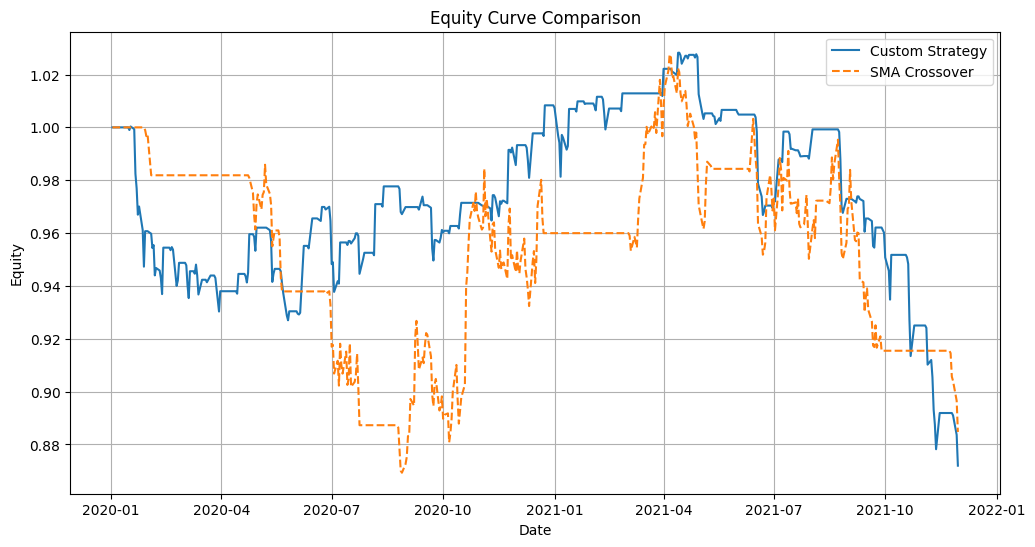

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def sharpe_ratio(returns, risk_free_rate=0, trading_days=252):
    """
    Calculate annualized Sharpe Ratio.

    Parameters:
      returns: pd.Series
          Daily net returns.
      risk_free_rate: float
          Risk free rate (default=0).
      trading_days: int
          Number of trading days in a year.

    Returns:
      Annualized Sharpe Ratio.
    """
    mean_daily = returns.mean()
    std_daily = returns.std()
    if std_daily == 0:
        return np.nan
    daily_sharpe = (mean_daily - risk_free_rate) / std_daily
    annual_sharpe = daily_sharpe * np.sqrt(trading_days)
    return annual_sharpe

def max_drawdown(equity_curve):
    """
    Calculate the maximum drawdown (peak-to-trough decline).

    Parameters:
      equity_curve: pd.Series
          Cumulative equity curve (starting at 1).

    Returns:
      Maximum drawdown as a negative float.
    """
    running_max = equity_curve.cummax()
    drawdown = equity_curve / running_max - 1
    return drawdown.min()

def calculate_trade_returns(data):
    """
    Extract individual trade returns.
    A trade is defined as the period from a buy signal (1) to a sell signal (-1).

    Parameters:
      data: pd.DataFrame
          Must contain 'signal' and 'close' columns.

    Returns:
      List of trade returns.
    """
    trades = []
    in_trade = False
    entry_price = None
    for i in range(len(data)):
        signal = data['signal'].iloc[i]
        price = data['close'].iloc[i]
        if not in_trade and signal == 1:
            in_trade = True
            entry_price = price
        elif in_trade and signal == -1:
            exit_price = price
            trade_return = exit_price / entry_price - 1
            trades.append(trade_return)
            in_trade = False
            entry_price = None
    # Close any open trade at the end of the period.
    if in_trade:
        exit_price = data['close'].iloc[-1]
        trade_return = exit_price / entry_price - 1
        trades.append(trade_return)
    return trades

def win_rate(data):
    """
    Calculate the win rate as the percentage of profitable trades.

    Parameters:
      data: pd.DataFrame
          Must contain 'signal' and 'close' columns.

    Returns:
      Win rate as a float between 0 and 1.
    """
    trades = calculate_trade_returns(data)
    if len(trades) == 0:
        return np.nan
    wins = [t for t in trades if t > 0]
    return len(wins) / len(trades)

def CAGR(equity_curve, trading_days=252):
    """
    Calculate the Compound Annual Growth Rate (CAGR).

    Parameters:
      equity_curve: pd.Series
          Cumulative equity curve (starting at 1).
      trading_days: int
          Number of trading days in a year.

    Returns:
      CAGR as a float.
    """
    n = len(equity_curve)
    final_value = equity_curve.iloc[-1]
    return final_value**(trading_days/n) - 1

def sma_crossover_strategy(data, short_window=20, long_window=50, transaction_cost=0.001):
    """
    Baseline strategy: SMA crossover.

    Buy when the short-term SMA exceeds the long-term SMA, and exit otherwise.
    Transaction costs are applied on every change in position.

    Parameters:
      data: pd.DataFrame
          Must contain a 'close' column.
      short_window: int
          Window for the short SMA.
      long_window: int
          Window for the long SMA.
      transaction_cost: float
          Cost per trade.

    Returns:
      pd.DataFrame with SMA signals, positions, net returns, and the equity curve.
    """
    df = data.copy()
    df['short_SMA'] = df['close'].rolling(window=short_window, min_periods=1).mean()
    df['long_SMA'] = df['close'].rolling(window=long_window, min_periods=1).mean()

    # Generate signals: 1 for buy, 0 for exit.
    df['signal'] = 0
    df.loc[df['short_SMA'] > df['long_SMA'], 'signal'] = 1
    df.loc[df['short_SMA'] <= df['long_SMA'], 'signal'] = 0

    # Compute positions (forward fill the signal)
    df['position'] = df['signal'].ffill().fillna(0)

    # Compute daily returns using the previous day's position (avoid lookahead bias)
    df['daily_return'] = df['close'].pct_change() * df['position'].shift(1).fillna(0)

    # Apply transaction cost on position changes
    df['trade'] = df['position'].diff().abs()
    df['cost'] = df['trade'] * transaction_cost
    df['net_return'] = df['daily_return'] - df['cost']

    # Create the equity curve (starting at 1)
    df['equity_curve'] = (1 + df['net_return']).cumprod()

    return df

def strategy_metrics(strategy_df, risk_free_rate=0):
    """
    Compute key performance metrics for a given strategy.

    Parameters:
      strategy_df: pd.DataFrame
          Must contain 'net_return', 'equity_curve', 'signal', and 'close'.
      risk_free_rate: float
          Risk-free rate for Sharpe ratio calculation.

    Returns:
      Dictionary of metrics.
    """
    returns = strategy_df['net_return'].dropna()
    sr = sharpe_ratio(returns, risk_free_rate)
    mdd = max_drawdown(strategy_df['equity_curve'])
    cagr_val = CAGR(strategy_df['equity_curve'])
    wr = win_rate(strategy_df)

    return {
        'Sharpe Ratio': sr,
        'Max Drawdown': mdd,
        'CAGR': cagr_val,
        'Win Rate': wr
    }

def plot_equity_curves(strategy_df, baseline_df):
    """
    Plot the equity curves for the custom strategy and the SMA crossover baseline.

    Parameters:
      strategy_df: pd.DataFrame
          DataFrame with the custom strategy equity curve in 'equity_curve'.
      baseline_df: pd.DataFrame
          DataFrame with the SMA crossover equity curve in 'equity_curve'.
    """
    plt.figure(figsize=(12,6))
    plt.plot(strategy_df.index, strategy_df['equity_curve'], label='Custom Strategy')
    plt.plot(baseline_df.index, baseline_df['equity_curve'], label='SMA Crossover', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Equity')
    plt.title('Equity Curve Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

# Create a sample dataset
np.random.seed(42)
dates = pd.date_range(start='2020-01-01', periods=500, freq='B')  # Business days
prices = 100 + np.cumsum(np.random.randn(len(dates)))  # Simulated random walk
data = pd.DataFrame({'close': prices}, index=dates)
# Custom strategy: using a dummy prediction (e.g., a 3-day rolling average shifted to avoid lookahead bias)
data['pred_price'] = data['close'].rolling(window=3, min_periods=1).mean().shift(1)
threshold = 0.005  # 0.5%
data['signal'] = 0
data.loc[data['pred_price'] > data['close'] * (1 + threshold), 'signal'] = 1
data.loc[data['pred_price'] < data['close'] * (1 - threshold), 'signal'] = -1

# Compute positions based on signals (1 for long, 0 for no position)
data['position'] = data['signal'].replace({1: 1, -1: 0}).ffill().fillna(0)
data['daily_return'] = data['close'].pct_change() * data['position'].shift(1).fillna(0)
data['trade'] = data['position'].diff().abs()
data['cost'] = data['trade'] * 0.001  # 0.1% per trade
data['net_return'] = data['daily_return'] - data['cost']
data['equity_curve'] = (1 + data['net_return']).cumprod()
# Compute baseline SMA crossover strategy
sma_df = sma_crossover_strategy(data, short_window=20, long_window=50, transaction_cost=0.001)
# Calculate metrics for both strategies
custom_metrics = strategy_metrics(data)
sma_metrics = strategy_metrics(sma_df)
print("Custom Strategy Metrics:")
for metric, value in custom_metrics.items():
    print(f"{metric}: {value:.4f}")
print("\nSMA Crossover Metrics:")
for metric, value in sma_metrics.items():
    print(f"{metric}: {value:.4f}")
# Plot the equity curves comparison
plot_equity_curves(data, sma_df)


In [18]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.7 MB/s eta 0:00:00


In [19]:
import optuna
import numpy as np

def objective(trial):
    # Hyperparameter tuning:
    seq_length = trial.suggest_int("sequence_length", 30, 100)
    lstm_layers = trial.suggest_int("lstm_layers", 1, 3)
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    training_window_years = trial.suggest_int("training_window", 3, 7)

    # --- Placeholder for training the LSTM model ---
    # In your actual implementation, replace the code below with your training routine.
    # For example:
    #
    # sharpe = train_lstm_model(
    #     sequence_length=seq_length,
    #     lstm_layers=lstm_layers,
    #     dropout_rate=dropout_rate,
    #     learning_rate=learning_rate,
    #     training_window_years=training_window_years,
    # )
    #
    # Here, we simulate the Sharpe Ratio by a function of the hyperparameters plus noise.
    # Assume higher sequence lengths and more layers might help up to a point,
    # while too high dropout or learning rates might hurt performance.

    # Dummy function to simulate Sharpe Ratio:
    base = 1.0
    bonus = (seq_length - 30) / 100.0 + (lstm_layers - 1) * 0.2
    penalty = dropout_rate * 0.5 + np.log10(learning_rate * 1e4) * 0.1
    noise = np.random.normal(scale=0.1)
    sharpe = base + bonus - penalty + noise

    # For a real study, replace the dummy "sharpe" with your actual computed metric.
    return sharpe


# Create or load a study with SQLite storage; set direction="maximize" for Sharpe Ratio.
study = optuna.create_study(
    study_name="lstm_hyperparam_opt",
    storage="sqlite:///lstm_optuna.db",
    load_if_exists=True,
    direction="maximize"
)

# Optimize the objective function with 50 trials.
study.optimize(objective, n_trials=50)
# Print out the best trial's parameters and value.
best_trial = study.best_trial
print("Best Sharpe Ratio: {:.4f}".format(best_trial.value))
print("Optimal hyperparameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")


[I 2025-03-02 11:35:27,798] A new study created in RDB with name: lstm_hyperparam_opt
<ipython-input-19-211d4530305d>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-03-02 11:35:28,040] Trial 0 finished with value: 1.1574642873823224 and parameters: {'sequence_length': 30, 'lstm_layers': 3, 'dropout_rate': 0.47278976673861217, 'learning_rate': 0.00097182001665028, 'training_window': 5}. Best is trial 0 with value: 1.1574642873823224.
[I 2025-03-02 11:35:28,186] Trial 1 finished with value: 1.4590781557584003 and parameters: {'sequence_length': 56, 'lstm_layers': 3, 'dropout_rate': 0.3881182302209406, 'learning_rate': 0.009507009585307381, 'training_window': 3}. Best is trial 1 with value: 1.4590781557584003.
[I 2025-03-02 11:35:28,370] Trial 2 finish

Best Sharpe Ratio: 2.1417
Optimal hyperparameters:
  sequence_length: 100
  lstm_layers: 3
  dropout_rate: 0.1101006129486525
  learning_rate: 0.00010941786212358706
  training_window: 6


In [21]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# --- Sample Data Setup ---
# Generate a sample date range and simulate price data.
dates = pd.date_range(start='2020-01-01', periods=200, freq='B')
np.random.seed(42)
price = 100 + np.cumsum(np.random.randn(len(dates)))
df = pd.DataFrame({'close': price}, index=dates)

# Simulate predicted prices (for example, one-day ahead prediction)
df['pred_price'] = df['close'].shift(-1)  # dummy prediction for demonstration

# Generate trade signals: buy (1) if predicted > close, sell (-1) if predicted < close.
df['signal'] = 0
df.loc[df['pred_price'] > df['close'], 'signal'] = 1
df.loc[df['pred_price'] < df['close'], 'signal'] = -1

# --- Bollinger Bands Calculation ---
window = 20
df['sma'] = df['close'].rolling(window=window).mean()
df['std'] = df['close'].rolling(window=window).std()
df['upper_band'] = df['sma'] + 2 * df['std']
df['lower_band'] = df['sma'] - 2 * df['std']

# --- Simulated Equity Curves ---
# LSTM strategy: using close price returns as a placeholder.
df['lstm_equity'] = (1 + df['close'].pct_change()).cumprod()

# SMA strategy: simulate an equity curve by applying a small random adjustment.
df['sma_equity'] = df['lstm_equity'] * (1 + np.random.uniform(-0.05, 0.05, size=len(df)))

# Buy & Hold: cumulative product of daily returns.
df['bh_equity'] = (1 + df['close'].pct_change()).cumprod()

# --- Figure 1: Actual vs Predicted Prices with Slider ---
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=df.index, y=df['close'], mode='lines', name='Actual Price'))
fig1.add_trace(go.Scatter(x=df.index, y=df['pred_price'], mode='lines', name='Predicted Price'))
fig1.update_layout(
    title="Actual vs Predicted Prices (Test Period)",
    xaxis_title="Date",
    yaxis_title="Price",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=3, label="3m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    )
)
fig1.write_html("actual_vs_predicted.html")


# --- Figure 2: Trade Signals over Price Chart with Bollinger Bands ---
fig2 = go.Figure()
# Plot the closing price
fig2.add_trace(go.Scatter(x=df.index, y=df['close'], mode='lines', name='Close Price'))
# Plot Bollinger Bands
fig2.add_trace(go.Scatter(x=df.index, y=df['upper_band'], mode='lines', name='Upper Band',
                           line=dict(dash='dot')))
fig2.add_trace(go.Scatter(x=df.index, y=df['lower_band'], mode='lines', name='Lower Band',
                           line=dict(dash='dot')))
# Fill between the bands by converting the index to lists
x_fill = list(df.index) + list(df.index[::-1])
y_fill = list(df['upper_band']) + list(df['lower_band'][::-1])
fig2.add_trace(go.Scatter(
    x=x_fill,
    y=y_fill,
    fill='toself',
    fillcolor='rgba(173,216,230,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo="skip",
    showlegend=False
))
# Add markers for trade signals
buy_signals = df[df['signal'] == 1]
sell_signals = df[df['signal'] == -1]
fig2.add_trace(go.Scatter(x=buy_signals.index, y=buy_signals['close'],
                          mode='markers', name='Buy Signal',
                          marker=dict(symbol='triangle-up', size=10, color='green')))
fig2.add_trace(go.Scatter(x=sell_signals.index, y=sell_signals['close'],
                          mode='markers', name='Sell Signal',
                          marker=dict(symbol='triangle-down', size=10, color='red')))
fig2.update_layout(
    title="Trade Signals over Price Chart with Bollinger Bands",
    xaxis_title="Date",
    yaxis_title="Price"
)
fig2.write_html("trade_signals.html")



# --- Figure 3: Cumulative Returns Comparison ---
fig3 = go.Figure()
fig3.add_trace(go.Scatter(x=df.index, y=df['lstm_equity'], mode='lines', name='LSTM Strategy'))
fig3.add_trace(go.Scatter(x=df.index, y=df['sma_equity'], mode='lines', name='SMA Strategy'))
fig3.add_trace(go.Scatter(x=df.index, y=df['bh_equity'], mode='lines', name='Buy & Hold'))
fig3.update_layout(
    title="Cumulative Returns Comparison",
    xaxis_title="Date",
    yaxis_title="Equity Curve"
)
fig3.write_html("cumulative_returns.html")


print("Interactive Plotly figures saved as HTML files.")


Interactive Plotly figures saved as HTML files.
